# MS MARCO (Description) - PDO Prompt Optimization (Open-Ended)

This notebook runs PDO (Prompt Duel Optimizer) on the [**MS MARCO**](https://github.com/microsoft/msmarco) dataset as an open‑ended, context‑based question‑answering task, and evaluates the optimized prompt against simple baselines using an LLM judge.

Prerequisites:
- Set OPENROUTER_API_KEY in your project `.env` or load from a known path.
- Ensure `use-cases/ms_marco/config.yaml` exists and sets `optimization.task_type: open_ended` with a suitable `judge_requirement`.



## 1. Judge requirement and final metric alignment

For the evaluation of open-ended tasks, an increasing number of benchmarks now rely on LLM judges due to their flexibility and the availability of more capable frontier or fine-tuned models. In MS MARCO, we also use an LLM judge to evaluate the outputs generated by the model.

The final evaluation of a prompt involves comparing the LLM-generated response, produced in response to the instruction prompt, with the ground-truth answer using an LLM judge template as shown below.


In [4]:
JUDGE_PROMPT = """Begin your evaluation by carefully comparing the AI-generated answer with the reference solution. Identify any outputs that aren't true, as well as omissions, or deviations, and simulate human judgments in explaining how these impact the overall quality of the response. Ensure that your assessment is objective and consistent.

At the end of your evaluation, assign a score from 1 to 5 based on the following scale:

- 1: Very poor—does not meet the requirements or is significantly incorrect.
- 2: Poor—contains major errors or omissions.
- 3: Fair—adequate but with notable flaws.
- 4: Good—meets the requirements with minor errors.
- 5: Excellent—fully accurate and well-articulated.

[User Question]

{question}

[Reference Solution]

{ground_truth}

[AI-Generated Answer]

{prediction}

Your response should be a valid json string (no backticks) following this schema:

{{
    "explanation": "{{Detailed reasoning based on the comparison}}",
    "score": {{1-5}}
}}
"""

## 2. Initial prompt (prompts/prompt.txt)
This is the simple, neutral starting instruction used to seed PDO. It’s kept concise and domain-agnostic so evolution can explore useful variants.

In [5]:
initial_prompt = """You are an expert answerer. 
Read the question and the provided context (if any).
Write a concise, accurate answer in your own words.
"""

## 3. Judge requirement (optimization.judge_requirement)

For open-ended tasks, the rubric bullets used for pairwise prompt comparison should mirror the final evaluation criterion (in this case, an LLM judge scoring from 1 to 5). Here, we align the criterion with the goal of the open-ended QA task. This part can be flexibly adjusted by the user according to the desired quality of the final response for different types of open-ended tasks.

```yaml
optimization:
  task_type: open_ended
  judge_requirement: |
    - Accuracy: Correct and contextually faithful.
    - Relevance: Stays on-topic.
    - Clarity: Clear and well-structured.
    - Conciseness: Uses only necessary information; avoids unnecessary detail.
```


## 4. Run Label-free PDO Optimization


Now, we are ready to run PDO on the open-ended MS MARCO task using the configurations described above.

In [ ]:
from dotenv import load_dotenv
load_dotenv("/Users/yuanchenwu/Downloads/prompt-ops/local.env")
!prompt-ops migrate --config config.yaml --log-level INFO

After running PDO, we store the optimized prompt as follows, ready for final evaluation.

In [16]:
OPTIMIZED_PROMPT = (
    """Embody the role of a knowledgeable researcher and provide a clear, 
    step-by-step explanation to answer the user's question, utilizing the provided 
    context and avoiding technical jargon unless absolutely necessary, to ensure a 
    concise and accurate response."""
)

## 5. Evaluate the optimized prompt with LLM judge

In this section, we evaluate the performance of the optimized prompt after running PDO against the initial prompt. We compare generated answers against ground truth using the judge prompt from Section 1 (returns JSON with explanation + 1–5 score).


In [ ]:
def judge_scores(preds: list[str]):
    """Judge with guided JSON decoding (fallback to free-form if unsupported)."""
    import json as _json
    import numpy as _np

    scores = []
    explanations = []
    judge_prompts = []
    for pred, r in zip(preds, rows):
        judge_prompts.append(
            JUDGE_PROMPT.format(
                question=r["question"],
                ground_truth=r["answer"],
                prediction=pred,
            )
        )

    response_format = {
        "type": "json_schema",
        "json_schema": {
            "name": "judge_score",
            "schema": {
                "type": "object",
                "properties": {
                    "explanation": {
                        "type": "string",
                        "description": "Detailed reasoning based on the comparison",
                    },
                    "score": {
                        "type": "integer",
                        "description": "Score from 1 to 5",
                        "enum": [1, 2, 3, 4, 5],
                    },
                },
                "required": ["explanation", "score"],
                "additionalProperties": False,
            },
            "strict": True,
        },
    }

    try:
        outs = model.generate_batch(
            judge_prompts, max_threads=10, temperature=0.0, response_format=response_format
        )
    except Exception:
        outs = model.generate_batch(
            judge_prompts, max_threads=10, temperature=0.0
        )

    for o in outs:
        obj = _try_json_parse(o)
        score = obj.get("score", 0)
        exp = obj.get("explanation", "")
        try:
            score = float(score)
        except Exception:
            score = 0.0
        scores.append(score)
        explanations.append(exp)
    return _np.array(scores), explanations

In [ ]:
import os, json
import numpy as np
from pathlib import Path

import sys
sys.path.append(os.path.abspath("../../src"))

from prompt_ops.core.model import setup_model

# Load dataset
DATA_PATH = "dataset/ms_marco_description.json"
rows = json.load(open(DATA_PATH, "r"))

# Model for answering and for judging (same adapter; different prompts)
model = setup_model(
    adapter_type="litellm",
    model_name="openrouter/meta-llama/llama-3.3-70b-instruct",
    api_base=os.environ.get("OPENROUTER_API_BASE", "https://openrouter.ai/api/v1"),
    api_key=os.environ.get("OPENROUTER_API_KEY"),
    max_tokens=4096,
    temperature=0.0,
)

# Helper
def _try_json_parse(s: str):
    try:
        start = s.find("{"); end = s.rfind("}") + 1
        blob = s[start:end] if (start >= 0 and end > start) else s
        return json.loads(blob)
    except Exception:
        return {}

# Baselines and PDO instruction
BASELINES = {
    "Initial Prompt": """You are an expert answerer. 
Read the question and the provided context (if any).
Write a concise, accurate answer in your own words.
""",
}


def predict_answers(instruction: str):
    prompts = []
    for r in rows:
        q = r["question"].strip()
        prompts.append(f"{instruction}\n\nQuestion:\n{q}")
    return model.generate_batch(prompts, max_threads=10, temperature=0.0)

results = {}

# Evaluate baselines
for name, instr in BASELINES.items():
    print(f"evaluating... {name}")
    preds = predict_answers(instr)
    s, _ = judge_scores(preds)
    results[name] = float(np.mean(s)) if len(s) else 0.0

# Evaluate PDO (if you paste the optimized instruction)
if OPTIMIZED_PROMPT:
    print("evaluating... PDO")
    preds = predict_answers(OPTIMIZED_PROMPT)
    s, _ = judge_scores(preds)
    results["PDO"] = float(np.mean(s)) if len(s) else 0.0

print("\n=== LLM Judge Avg Score (1–5) on MS MARCO Description ===")
for k, v in results.items():
    print(f"{k}: {v:.2f}")


2025-11-11 01:28:58,646 | INFO    |  Using model with LiteLLM: openrouter/meta-llama/llama-3.3-70b-instruct


evaluating... Initial Prompt
evaluating... PDO

=== LLM Judge Avg Score (1–5) on MS MARCO Description ===
Initial Prompt: 4.48
PDO: 4.64


PDO achieves a **higher average LLM judge score (4.64)** than the Initial Prompt (4.48) on the MS MARCO Description, indicating a measurable improvement in answer quality.

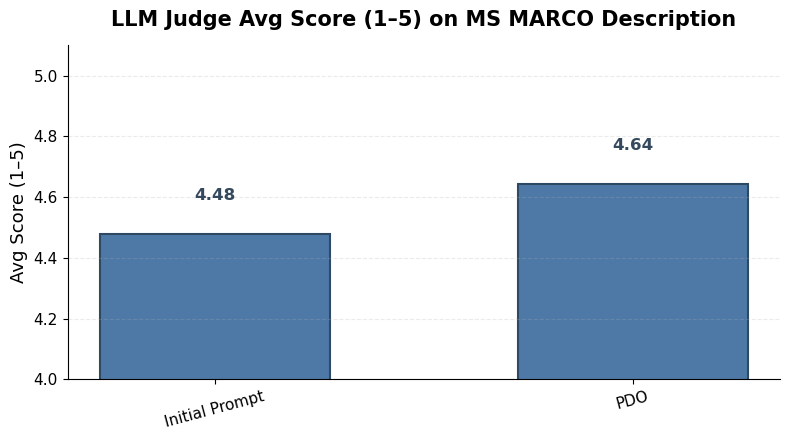

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4.5))
bars = plt.bar(results.keys(), results.values(), color="#4e79a7", edgecolor="#2e4a62", linewidth=1.5, width=0.55)
plt.title("LLM Judge Avg Score (1–5) on MS MARCO Description", fontsize=15, fontweight="bold", pad=14)
plt.ylabel("Avg Score (1–5)", fontsize=13)
plt.ylim(4, 5.1)
plt.xticks(rotation=15, fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.25)

for bar, v in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width() / 2, v + 0.10, f"{v:.2f}", ha="center", va="bottom", fontsize=12, fontweight="bold", color="#34495e")

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()